In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [3]:
# Load Data and Preprocess
def load_data(filepath):
    df = pd.read_csv(filepath)

    # Label encode categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    # Scale numeric values
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(df)

    return df, x_scaled

#================ FOR PCA Dimensionality reduction =========
# Apply PCA for Dimensionality Reduction
def apply_pca(x, n_components):
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(x)
    return x_pca, pca

#================ FOR K-Means ===============================
# Find Optimal Clusters for KMeans (Elbow Method)
def find_optimal_clusters(x, max_clusters=10):
    inertia = []
    for k in range(2, max_clusters + 1):
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(x)
        inertia.append(model.inertia_)

    plt.figure(figsize=(8,5))
    plt.plot(range(2, max_clusters + 1), inertia, marker='o')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.title("Elbow Method")
    plt.show()

    return inertia

# Perform KMeans Clustering
# Change None to the number of n_clusters value from the elbow method
def perform_kmeans_clustering(x, n_clusters=None):
    if n_clusters is None:
        raise ValueError("Please provide n_clusters.")
    model = KMeans(n_clusters=n_clusters, random_state=42)
    labels = model.fit_predict(x)
    return labels, model

#================ FOR Agglomerative ===============================
# Perform Agglomerative Clustering
# Change None to the number of n_clusters value from the elbow method
def perform_agglomerative_clustering(x, n_clusters=None):
    if n_clusters is None:
        raise ValueError("Please provide n_clusters.")
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = model.fit_predict(x)
    return labels, model

#================FOR Dendrogram===============================
# Get Linkages for Dendrogram
def get_linkages(x):
    linked = linkage(x, method='ward')
    return linked

# Plot Dendrogram
def plot_dendrogram(linked):
    plt.figure(figsize=(10,6))
    dendrogram(linked)
    plt.title("Dendrogram")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()


## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

In [4]:
def load_data(filepath):
    """Load and preprocess the bank marketing dataset.

    TODO:
    1. Load the CSV file (hint: it uses semicolon separator)
    2. Convert categorical columns to numerical using LabelEncoder
    3. Scale the features using StandardScaler
    """
    # Your code here:
    # Load data
    df = pd.read_csv(filepath, sep=';', low_memory=False)

    # FIX mixed type numeric columns by coercing
    df['balance'] = pd.to_numeric(df['balance'], errors='coerce')
    df['campaign'] = pd.to_numeric(df['campaign'], errors='coerce')
    df['previous'] = pd.to_numeric(df['previous'], errors='coerce')
    df = df.fillna(0)

    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                        'loan', 'contact', 'month', 'poutcome', 'y']

    # Convert categorical columns to string BEFORE encoding
    df[categorical_cols] = df[categorical_cols].astype(str)

    # TODO: Apply label encoding to categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education',
                'housing', 'loan', 'default']
    X = df[features]  # TODO: Select features

    # TODO: Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # TODO: Apply StandardScaler

    return X_scaled, df


# Load and preprocess the data
X_scaled, data = load_data('bank-full.csv')
print("Data shape:", X_scaled.shape)

Data shape: (45211, 9)


In [5]:
class KMeansClustering:
    """Minimal K-means skeleton for students to implement.

    Students should implement the core methods below:
    - _initialize_centroids
    - _assign_clusters
    - _update_centroids
    - fit
    """

    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Initialize centroids.

        TODO (student):
        - Randomly select `n_clusters` distinct points from X as initial centroids.
        """
        np.random.seed(self.random_state)
        indices = np.random.choice(len(X), self.n_clusters, replace=False)
        centroids = X[indices]
        return centroids

    def _assign_clusters(self, X):
        """Assign each sample in X to the nearest centroid.

        TODO (student):
        - Compute Euclidean distance from each point to each centroid
        """
        # distances shape = (n_samples, n_clusters)
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

    def _update_centroids(self, X, labels):
        """Recompute centroids as mean of points in each cluster."""
        new_centroids = []

        for k in range(self.n_clusters):
            cluster_points = X[labels == k]

            if len(cluster_points) == 0:
                # Cluster empty → reinitialize centroid
                new_centroids.append(self.centroids[k])
            else:
                new_centroids.append(cluster_points.mean(axis=0))

        return np.array(new_centroids)

    def fit(self, X):
        """Run K-means until convergence or max_iters."""
        # Step 1: initialize
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iters):
            # Step 2: assign
            labels = self._assign_clusters(X)

            # Step 3: compute new centroids
            new_centroids = self._update_centroids(X, labels)

            # Step 4: convergence check
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

        self.labels = labels
        return self  # allow chaining

    def predict(self, X):
        """Assign cluster labels to X using the learned centroids."""
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)


## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

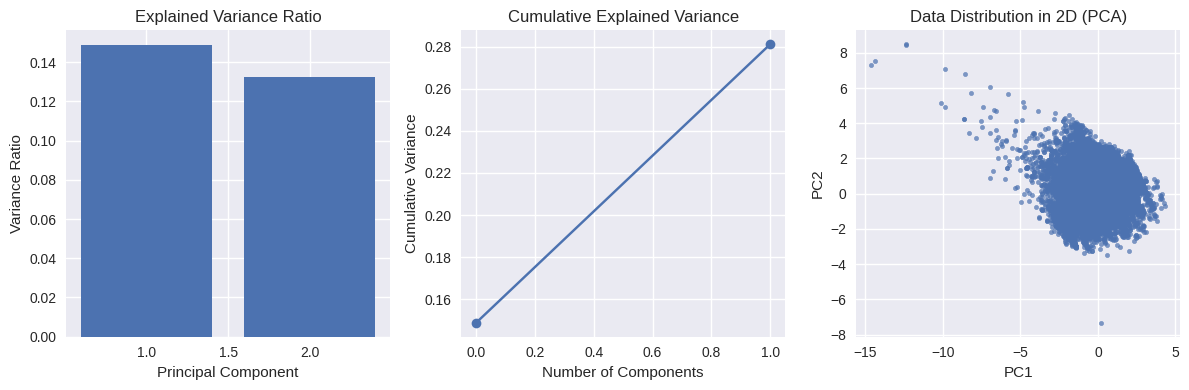

Shape after PCA: (45211, 2)


/tmp/ipython-input-3390247004.py:52: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_corr = df_corr.apply(pd.to_numeric, errors='ignore')


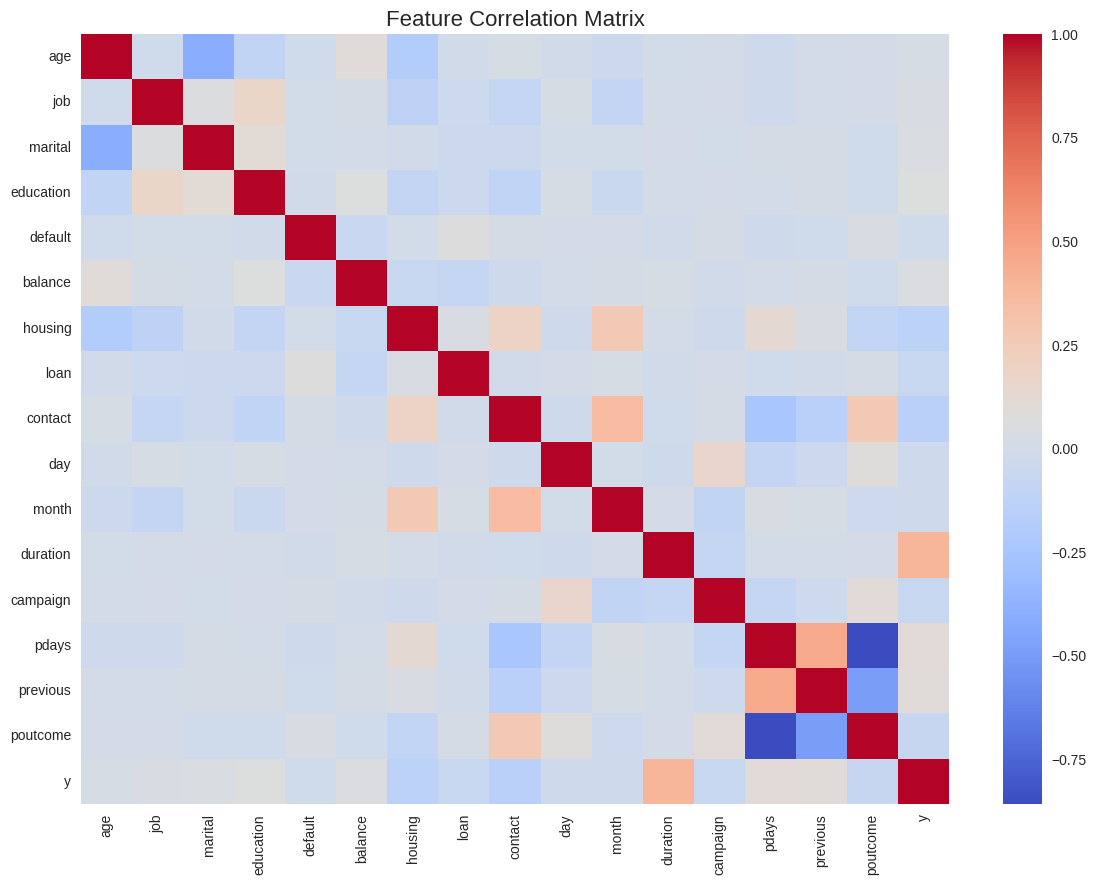

In [6]:
def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction.

    TODO:
    1. Initialize and fit PCA
    2. Transform the data
    3. Create visualizations to understand:
       - Explained variance ratio
       - Cumulative explained variance
       - Data distribution in 2D
    """
    # Your code here:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # TODO: Create visualization
    plt.figure(figsize=(12, 4))

    # --- Plot explained variance ratio ---
    plt.subplot(1, 3, 1)
    plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_)
    plt.title("Explained Variance Ratio")
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Ratio")

    # --- Plot cumulative explained variance ---
    plt.subplot(1, 3, 2)
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.title("Cumulative Explained Variance")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance")

    # --- Plot data distribution in 2D ---
    plt.subplot(1, 3, 3)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.7)
    plt.title("Data Distribution in 2D (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.tight_layout()
    plt.show()

    return X_pca

# Apply PCA
X_pca = apply_pca(X_scaled)
print("Shape after PCA:", X_pca.shape)


# Create correlation matrix of the processed data
df_corr = data.copy()
df_corr = df_corr.apply(pd.to_numeric, errors='ignore')

plt.figure(figsize=(14, 10))
sns.heatmap(df_corr.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix", fontsize=16)
plt.show()


## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

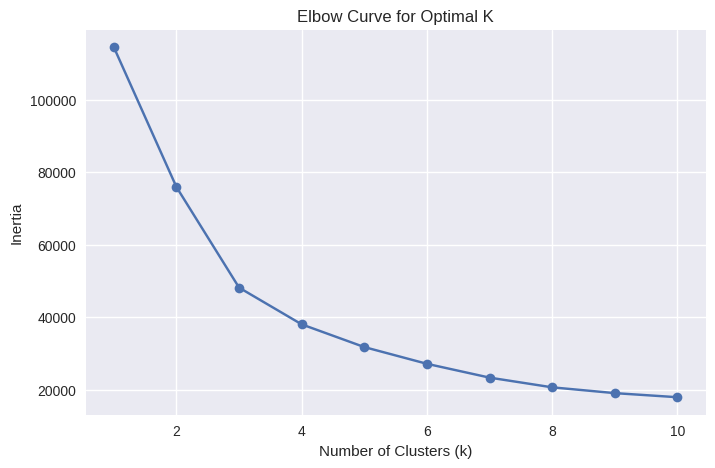

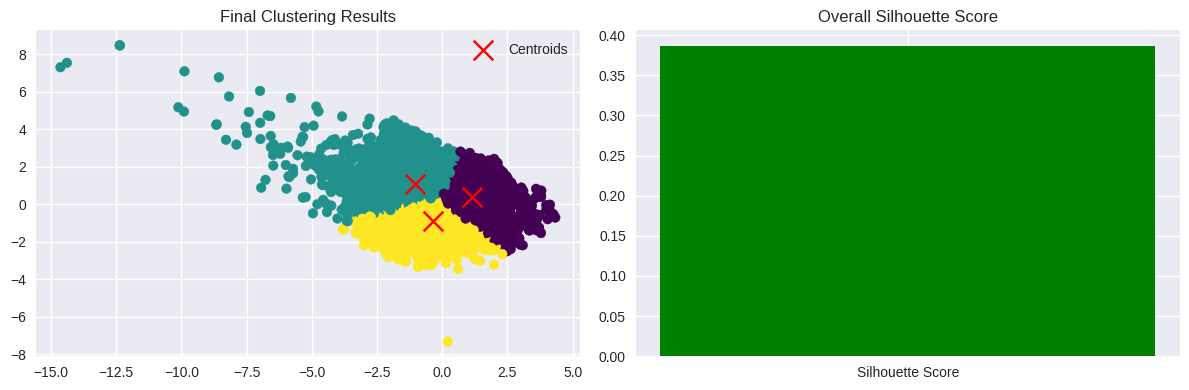

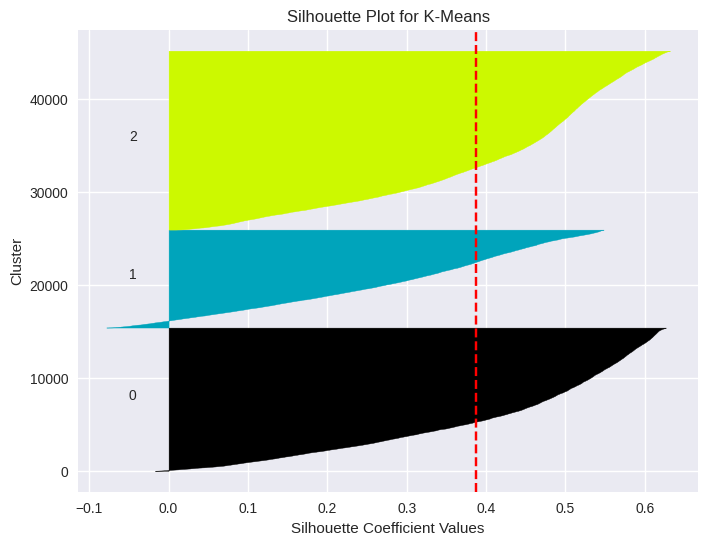


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score: 0.39


In [7]:
def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia).

    TODO:
    1. For each cluster, calculate the sum of squared distances
       between points and their centroid
    2. Sum up all cluster distances
    """
    inertia = 0
    for k in range(len(centroids)):
        cluster_points = X[labels == k]
        distances = np.linalg.norm(cluster_points - centroids[k], axis=1) ** 2
        inertia += distances.sum()
    return inertia


def plot_elbow_curve(X, max_k=10):
    """Plot the elbow curve to find optimal number of clusters.

    TODO:
    1. Try different values of k (1 to max_k)
    2. Calculate inertia for each k
    3. Plot k vs inertia
    4. Help identify the 'elbow' point
    """
    inertias = []
    K = range(1, max_k + 1)

    for k in K:
        km = KMeansClustering(n_clusters=k)
        km.fit(X)
        inertia = calculate_inertia(X, km.labels, km.centroids)
        inertias.append(inertia)

    # Create elbow plot
    plt.figure(figsize=(8, 5))
    plt.plot(K, inertias, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title("Elbow Curve for Optimal K")
    plt.grid(True)
    plt.show()

    return inertias


# Try different numbers of clusters
inertias = plot_elbow_curve(X_pca)

# Apply final clustering
kmeans = KMeansClustering(n_clusters=3)  # Try different values based on elbow curve
kmeans.fit(X_pca)

# -------- SILHOUETTE PLOT FUNCTION (new) --------
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def plot_silhouette(X, labels, n_clusters):
    silhouette_vals = silhouette_samples(X, labels)
    y_lower = 10
    plt.figure(figsize=(8, 6))

    for i in range(n_clusters):
        ith_vals = silhouette_vals[labels == i]
        ith_vals.sort()
        size_i = len(ith_vals)
        y_upper = y_lower + size_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals,
                          facecolor=color, edgecolor=color)

        plt.text(-0.05, y_lower + size_i / 2, str(i))
        y_lower = y_upper + 10

    plt.axvline(x=silhouette_score(X, labels), color="red", linestyle="--")
    plt.title("Silhouette Plot for K-Means")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster")
    plt.show()


# -------- VISUALIZE FINAL CLUSTERS + METRICS --------
plt.figure(figsize=(12, 4))

# Plot clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1],
            c='red', marker='x', s=200, label='Centroids')
plt.title('Final Clustering Results')
plt.legend()

# Silhouette BAR (optional but ok to keep)
plt.subplot(1, 2, 2)
sil_per_point = silhouette_score(X_pca, kmeans.labels)
plt.bar(['Silhouette Score'], [sil_per_point], color='green')
plt.title("Overall Silhouette Score")

plt.tight_layout()
plt.show()

# -------- NEW: FULL SILHOUETTE DISTRIBUTION PLOT --------
plot_silhouette(X_pca, kmeans.labels, n_clusters=3)

# -------- PRINT METRICS --------
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
silhouette = silhouette_score(X_pca, kmeans.labels)

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")


## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

In [8]:
class BisectingKMeans:
    """Concise skeleton for students to implement a bisecting K-means algorithm.

    Students should implement `fit_predict` to recursively split clusters until
    `n_clusters` is reached.
    """
    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        # Optional: store mapping parent -> (left_label, right_label)
        self.split_tree = {}
        # Optional: store centroids per cluster id
        self.centers_ = {}

    def fit_predict(self, X):
        """Recursively bisect clusters until `n_clusters` is reached.

        TODO (student):
        - Start with all points assigned to label 0.
        - While number of unique labels < n_clusters:
            - Select a cluster to split (e.g., the largest cluster by size)
            - Run a binary KMeans (k=2) on the points in that cluster
            - Assign new labels (keep one child label as the original, give the other a new id)
            - Record parent -> (left, right) in `self.split_tree` and centroids in `self.centers_`
        - Set and return `self.labels_` (numpy array of length n_samples)
        """

        # Start: all points belong to cluster 0
        labels = np.zeros(len(X), dtype=int)
        current_max_label = 0

        # Loop until reaching desired number of clusters
        while len(np.unique(labels)) < self.n_clusters:

            # 1. Pick the largest cluster to split
            unique, counts = np.unique(labels, return_counts=True)
            largest_cluster = unique[np.argmax(counts)]

            # 2. Extract points in that cluster
            cluster_mask = (labels == largest_cluster)
            cluster_points = X[cluster_mask]

            # 3. Run binary KMeans on this subset
            km = KMeans(n_clusters=2, random_state=self.random_state)
            sub_labels = km.fit_predict(cluster_points)

            # 4. Assign new cluster labels
            left_child = largest_cluster
            right_child = current_max_label + 1

            # Replace labels
            new_labels = labels.copy()
            new_labels[cluster_mask] = np.where(sub_labels == 0, left_child, right_child)

            # Update labels
            labels = new_labels
            current_max_label = right_child

            # 5. Store metadata
            self.split_tree[largest_cluster] = (left_child, right_child)
            self.centers_[left_child] = km.cluster_centers_[0]
            self.centers_[right_child] = km.cluster_centers_[1]

        self.labels_ = labels
        return labels


## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!